# Load Data
In order to expediate the testing process, I added a debug flag to the pipeline method in our pipeline file which outputs the fixed and moving images prior to registration

In [24]:
import sys
sys.path.append('../code/functions')
sys.path.append('/home/simpleElastix/build/SimpleITK-build/Wrapping/Python')

import pickle
import cv2
import time

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from cluster import Cluster
from tiffIO import loadTiff, unzipChannels
from connectLib import adaptiveThreshold
from hyperReg import get3DRigid, parseTransformFile, apply3DRigid, apply3DRigidVolume

In [2]:
movingImg = pickle.load(open('../code/functions/movingDebug.io', 'r'))
fixedImg = pickle.load(open('../code/functions/fixedDebug.io', 'r'))
movingLmk = pickle.load(open('../code/functions/movingLDebug.io', 'r'))
fixedLmk = pickle.load(open('../code/functions/fixedLDebug.io', 'r'))

In [3]:
testFixedLmk = fixedLmk[10:15]
testMovingLmk = movingLmk[10:15]
testFixedImg = fixedImg[10:15]
testMovingImg = movingImg[10:15]

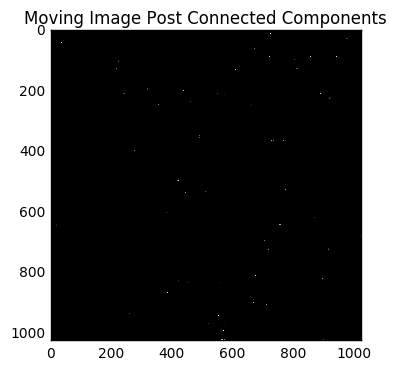

In [4]:
plt.figure()
plt.imshow(movingImg[10], cmap='gray')
plt.title('Moving Image Post Connected Components')
plt.show()

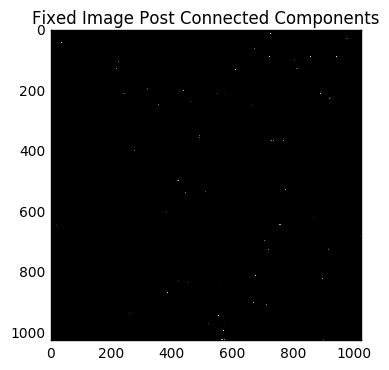

In [5]:
plt.figure()
plt.imshow(movingImg[10], cmap='gray')
plt.title('Fixed Image Post Connected Components')
plt.show()

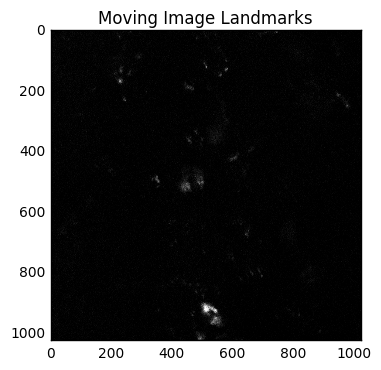

In [6]:
plt.figure()
plt.imshow(movingLmk[10], cmap='gray')
plt.title('Moving Image Landmarks')
plt.show()

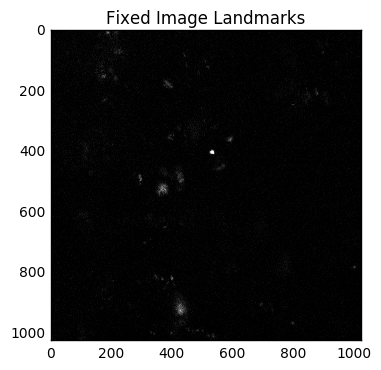

In [7]:
plt.figure()
plt.imshow(fixedLmk[10], cmap='gray')
plt.title('Fixed Image Landmarks')
plt.show()

# Visualization Function

In [8]:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 255
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

def visVolDiff(volumeA, volumeB):
    for i in range(volumeA.shape[0]):
        plt.figure()
        plt.title('Disperity at z=' + str(i))
        plt.imshow(visDiff(volumeA[i], volumeB[i]))
        plt.show()

# Registration Functions

In [9]:
def preproc(img):
    binImg = adaptiveThreshold(img, 5, 5)
    binImg*=255
    outImg = np.stack([cv2.erode(sub, None, 1) for sub in binImg])
    outImg = np.stack([cv2.dilate(sub, None, 2) for sub in outImg])

    return outImg

In [10]:
def register(landmarks1, landmarks2, additionalParams):
    SimpleElastix = sitk.SimpleElastix()

    SimpleElastix.LogToConsoleOn()

    img1 = nib.Nifti1Image(preproc(landmarks1), np.eye(4))
    nib.save(img1, 'fixed.nii')
    img2 = nib.Nifti1Image(preproc(landmarks2), np.eye(4))
    nib.save(img2, 'moving.nii')

    SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
    SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

    pMap = sitk.GetDefaultParameterMap('rigid')
    for elem in additionalParams:
        pMap[elem[0]]=[elem[1]]
    SimpleElastix.SetParameterMap(pMap)
    SimpleElastix.Execute()
    
    t = SimpleElastix.GetTransformParameterMap()
    sitk.WriteParameterFile(t[0], 'transform.txt')
    imgFilter = sitk.SimpleTransformix()
    imgFilter.SetTransformParameterMap(t[0])
    imgFilter.PrintParameterMap()
    return imgFilter

In [25]:
start = time.time()
myTransform = register(fixedLmk, movingLmk,
                        [['MaximumNumberOfSamplingAttempts','200'],
                         ['MaximumNumberOfIterations', '700'],
                         ['Metric', 'AdvancedMeanSquares']]
                      )
end = time.time()

0.00357142857143
0.00714285714286
0.0107142857143
0.0142857142857
0.0178571428571
0.0214285714286
0.025
0.0285714285714
0.0321428571429
0.0357142857143
0.0392857142857
0.0428571428571
0.0464285714286
0.05
0.0535714285714
0.0571428571429
0.0607142857143
0.0642857142857
0.0678571428571
0.0714285714286
0.075
0.0785714285714
0.0821428571429
0.0857142857143
0.0892857142857
0.0928571428571
0.0964285714286
0.1
0.103571428571
0.107142857143
0.110714285714
0.114285714286
0.117857142857
0.121428571429
0.125
0.128571428571
0.132142857143
0.135714285714
0.139285714286
0.142857142857
0.146428571429
0.15
0.153571428571
0.157142857143
0.160714285714
0.164285714286
0.167857142857
0.171428571429
0.175
0.178571428571
0.182142857143
0.185714285714
0.189285714286
0.192857142857
0.196428571429
0.2
0.203571428571
0.207142857143
0.210714285714
0.214285714286
0.217857142857
0.221428571429
0.225
0.228571428571
0.232142857143
0.235714285714
0.239285714286
0.242857142857
0.246428571429
0.25
0.253571428571
0.2571

In [26]:
print end - start

204.606409788


In [12]:
params = parseTransformFile('transform.txt')

In [13]:
regVolume = apply3DRigidVolume(fixedLmk,
                               params['matrix'],
                               params['originZ'],
                               params['originY'],
                               params['originX'])

0.0


../code/functions/hyperReg.py:61: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



0.00357142857143
0.00714285714286
0.0107142857143
0.0142857142857
0.0178571428571
0.0214285714286
0.025
0.0285714285714
0.0321428571429
0.0357142857143
0.0392857142857
0.0428571428571
0.0464285714286
0.05
0.0535714285714
0.0571428571429
0.0607142857143
0.0642857142857
0.0678571428571
0.0714285714286
0.075
0.0785714285714
0.0821428571429
0.0857142857143
0.0892857142857
0.0928571428571
0.0964285714286
0.1
0.103571428571
0.107142857143
0.110714285714
0.114285714286
0.117857142857
0.121428571429
0.125
0.128571428571
0.132142857143
0.135714285714
0.139285714286
0.142857142857
0.146428571429
0.15
0.153571428571
0.157142857143
0.160714285714
0.164285714286
0.167857142857
0.171428571429
0.175
0.178571428571
0.182142857143
0.185714285714
0.189285714286
0.192857142857
0.196428571429
0.2
0.203571428571
0.207142857143
0.210714285714
0.214285714286
0.217857142857
0.221428571429
0.225
0.228571428571
0.232142857143
0.235714285714
0.239285714286
0.242857142857
0.246428571429
0.25
0.253571428571
0.2571

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


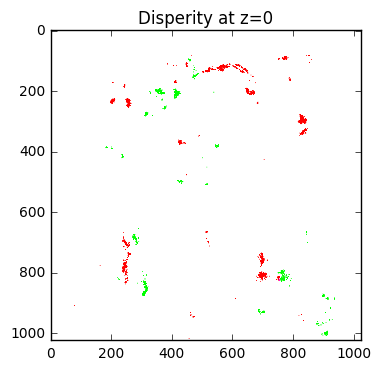

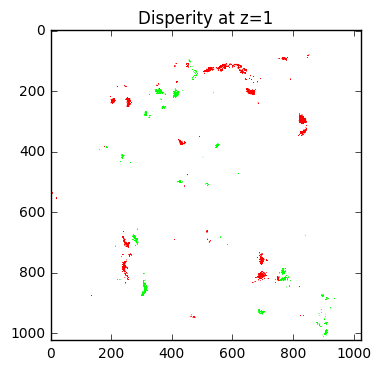

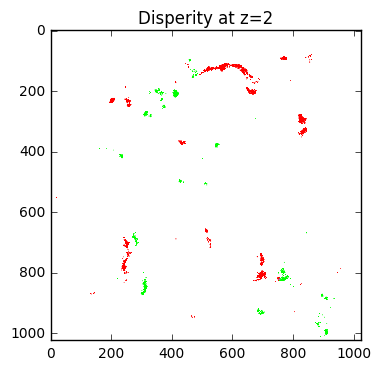

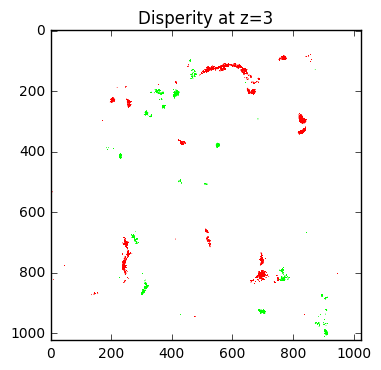

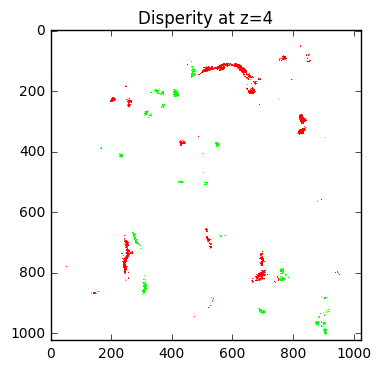

In [22]:
visVolDiff(preproc(fixedLmk[140:145]), preproc(movingLmk[140:145]))

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


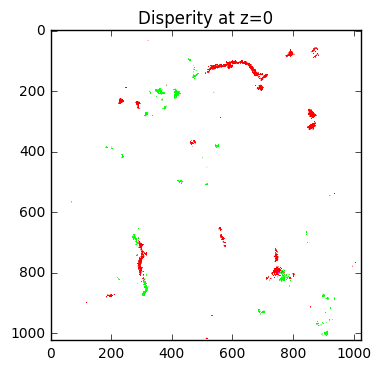

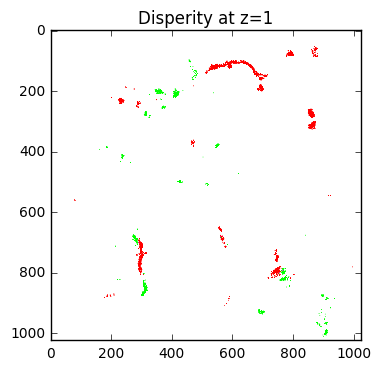

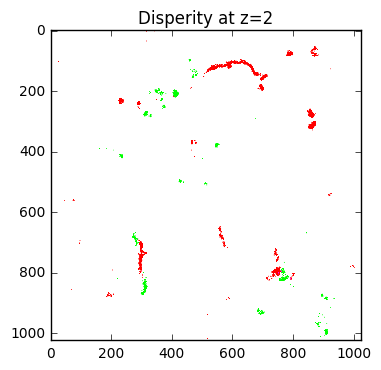

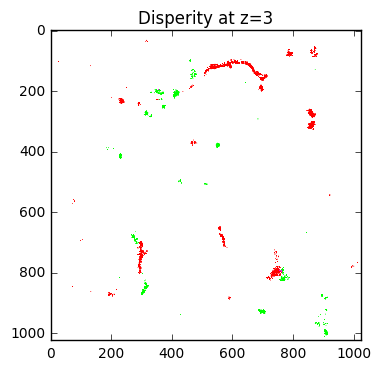

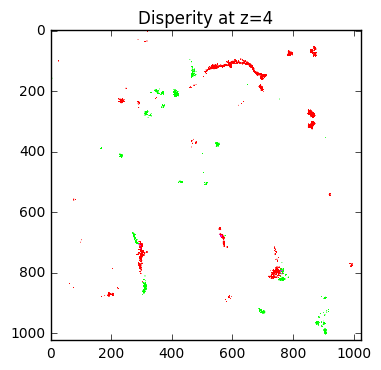

In [17]:
visVolDiff(preproc(regVolume[140:145]), preproc(movingLmk[140:145]))